In [3]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from scipy.stats import jarque_bera, skew, kurtosis
from statsmodels.stats.diagnostic import lilliefors, acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA

In [19]:
base_rep_path = Path(".")              
data_path     = base_rep_path / "data" 
figures_path  = base_rep_path / "figures"
tables_path   = base_rep_path / "tables"
processed_path= base_rep_path / "processed"

In [16]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [21]:
data_excel = data_path / "GoyalData2022.xlsx"
df1 = pd.read_excel(data_excel, engine="openpyxl")
df1.head()

C:\Users\Huong\OneDrive\Documents\Job\Project\early-regime\.venv\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,yyyymm,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx
0,187101,4.44,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,187102,4.50,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,0.004967,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,187103,4.61,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,0.004525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,187104,4.74,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,0.004252,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,187105,4.86,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,0.004643,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
selected_df1 = df1.iloc[660:].reset_index(drop=True)
print(selected_df1.shape)

(1164, 18)


In [27]:
# Simple returns (S&P500, risk-free rate, long-term bond)
r_SP500  = pd.to_numeric(selected_df1.iloc[:, 16], errors="coerce")
r_rf   = pd.to_numeric(selected_df1.iloc[:, 10], errors="coerce")     
r_ltb = pd.to_numeric(selected_df1.iloc[:, 12], errors="coerce")   

print("S&P500 first 5:", r_SP500.head().tolist())
print("Risk-free first 5:", r_rf.head().tolist())
print("LTB first 5:", r_ltb.head().tolist())

S&P500 first 5: [-0.001783, -0.033296, -0.057708, 0.038522, 0.013623]
Risk-free first 5: [0.0029249999999999996, 0.0029083333333333335, 0.00265, 0.002616666666666667, 0.0025666666666666667]
LTB first 5: [0.0138, 0.0063, 0.0041, 0.0076, 0.0014]


In [28]:
# log returns (S&P500, risk-free rate, long-term bond)
rl_SP500  = np.log1p(r_SP500.astype(float))
rl_rf   = np.log1p(r_rf.astype(float))
rl_ltb = np.log1p(r_ltb.astype(float))

In [30]:
# Excess log returns (S&P500, long-term bond)
excessrl_SP500 = rl_SP500 - rl_rf
excessrl_LTB   = rl_ltb - rl_rf

print("Excess S&P500 first 5:", excessrl_SP500.head().tolist())
print("Excess LTB first 5:", excessrl_LTB.head().tolist())

Excess S&P500 first 5: [-0.004705321947446235, -0.03676704404583721, -0.062086568611594534, 0.035185299355415596, 0.010967662761186998]
Excess LTB first 5: [0.010784916545134521, 0.0033761256430990872, 0.001445122962348029, 0.0049580163415122135, -0.00116435748945284]


In [39]:
# Normality tests on excess returns

# S&P500 excess returns
jb_stat_SP500, jb_p_SP500 = jarque_bera(excessrl_SP500.dropna())
lf_stat_SP500, lf_p_SP500 = lilliefors(excessrl_SP500.dropna(), dist="norm")

print("S&P500  — Jarque–Bera: stat =", round(jb_stat_sp, 4), " p-value =", round(jb_p_sp, 4))
print("S&P500  — Lilliefors:  stat =", round(lf_stat_sp, 4), " p-value =", round(lf_p_sp, 4))

# LTB excess returns
jb_stat_LTB, jb_p_LTB = jarque_bera(excessrl_LTB.dropna())
lf_stat_LTB, lf_p_LTB = lilliefors(excessrl_LTB.dropna(), dist="norm")

print("\nLTB     — Jarque–Bera: stat =", round(jb_stat_LTB, 4), " p-value =", round(jb_p_LTB, 4))
print("LTB     — Lilliefors:  stat =", round(lf_stat_LTB, 4), " p-value =", round(lf_p_LTB, 4))

S&P500  — Jarque–Bera: stat = 2787.3354  p-value = 0.0
S&P500  — Lilliefors:  stat = 0.0744  p-value = 0.001

LTB     — Jarque–Bera: stat = 626.4711  p-value = 0.0
LTB     — Lilliefors:  stat = 0.0731  p-value = 0.001


S&P500 Excess Returns Ljung-Box Q-test
      lb_stat  lb_pvalue
12  33.484114   0.000813


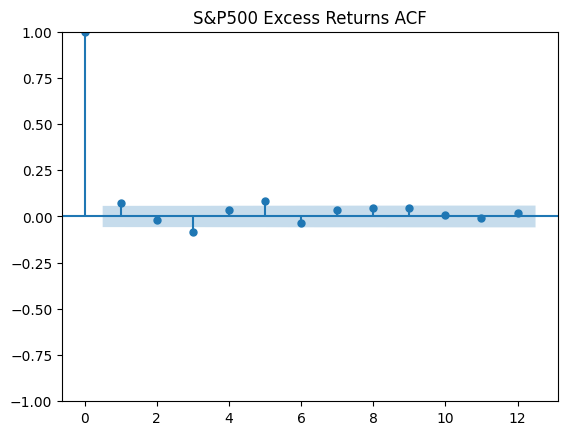


LTB Excess Returns Ljung-Box Q-test
      lb_stat  lb_pvalue
12  20.959091   0.050983


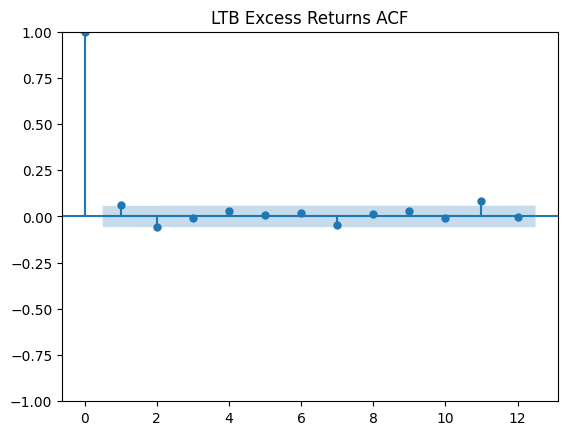

In [40]:
# Autocorrelation of excess returns (up to 12 lags)
lags = 12

# S&P500 excess returns
print("S&P500 Excess Returns Ljung-Box Q-test")
lbq_SP500 = acorr_ljungbox(excessrl_SP500.dropna(), lags=[lags], return_df=True)
print(lbq_SP500)

plot_acf(excessrl_SP500.dropna(), lags=lags, title="S&P500 Excess Returns ACF")
plt.show()

# LTB excess returns
print("\nLTB Excess Returns Ljung-Box Q-test")
lbq_LTB = acorr_ljungbox(excessrl_LTB.dropna(), lags=[lags], return_df=True)
print(lbq_LTB)

plot_acf(excessrl_LTB.dropna(), lags=lags, title="LTB Excess Returns ACF")
plt.show()

S&P500 Squared Excess Returns Ljung-Box Q-test
      lb_stat      lb_pvalue
12  727.94786  4.573950e-148


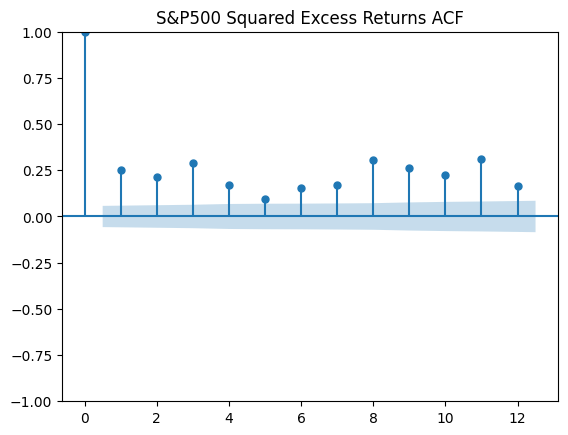


LTB Squared Excess Returns Ljung-Box Q-test
       lb_stat     lb_pvalue
12  348.743897  2.582184e-67


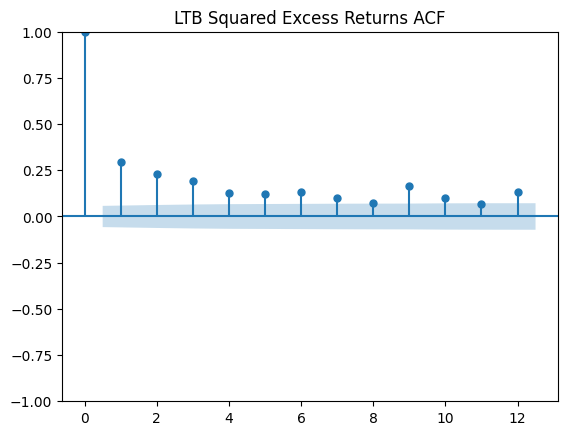

In [41]:
# Squared excess returns autocorrelation (evidence of volatility clustering -> motivates GARCH)

# Squared excess returns
sq_SP500 = excessrl_SP500 ** 2
sq_LTB   = excessrl_LTB ** 2

# S&P500 excess returns
print("S&P500 Squared Excess Returns Ljung-Box Q-test")
lbq_sq_SP500 = acorr_ljungbox(sq_SP500.dropna(), lags=[12], return_df=True)
print(lbq_sq_SP500)

plot_acf(sq_SP500.dropna(), lags=12, title="S&P500 Squared Excess Returns ACF")
plt.show()

# LTB excess returns
print("\nLTB Squared Excess Returns Ljung-Box Q-test")
lbq_sq_LTB = acorr_ljungbox(sq_LTB.dropna(), lags=[12], return_df=True)
print(lbq_sq_LTB)

plot_acf(sq_LTB.dropna(), lags=12, title="LTB Squared Excess Returns ACF")
plt.show()

In [45]:
# Fit AR(1), MA(1), ARMA(1,1)
AR1   = ARIMA(excessrl_SP500.dropna(), order=(1,0,0)).fit()
MA1   = ARIMA(excessrl_SP500.dropna(), order=(0,0,1)).fit()
ARMA11= ARIMA(excessrl_SP500.dropna(), order=(1,0,1)).fit()

# Residuals
e_AR1   = AR1.resid
e_MA1   = MA1.resid
e_ARMA11  = ARMA11.resid

# Total variance 
SSTot   = ((excessrl_SP500.dropna() - excessrl_SP500.dropna().mean())**2).sum()

# R² = 1 - SSE/SST
rsq_AR1  = 1 - (e_AR1**2).sum() / SSTot
rsq_MA1  = 1 - (e_MA1**2).sum() / SSTot
rsq_ARMA11 = 1 - (e_ARMA11**2).sum() / SSTot

print("R² AR(1):     ", round(rsq_AR1, 4))
print("R² MA(1):     ", round(rsq_MA1, 4))
print("R² ARMA(1,1): ", round(rsq_ARMA11, 4))

R² AR(1):      0.0055
R² MA(1):      0.0057
R² ARMA(1,1):  0.0057


In [48]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


In [60]:
# Fit GARCH(1,1) 
from arch import arch_model

# S&P500 excess returns
scaled_SP500 = excessrl_SP500.dropna() * 100 
ARCH_SP500 = arch_model(scaled_SP500, mean='Zero', vol='GARCH', p=1, q=1)
res_SP500 = ARCH_SP500.fit(disp='off')
vol_SP500_GARCH = (res_SP500.conditional_volatility / 100.0).rename("vol_SP500_GARCH")

# lTB excess returns
scaled_LTB = excessrl_LTB.dropna() * 100
ARCH_LTB = arch_model(scaled_LTB, mean='Zero', vol='GARCH', p=1, q=1)
res_LTB = ARCH_LTB.fit(disp='off')
vol_LTB_GARCH = (res_LTB.conditional_volatility / 100.0).rename("vol_LTB_GARCH")

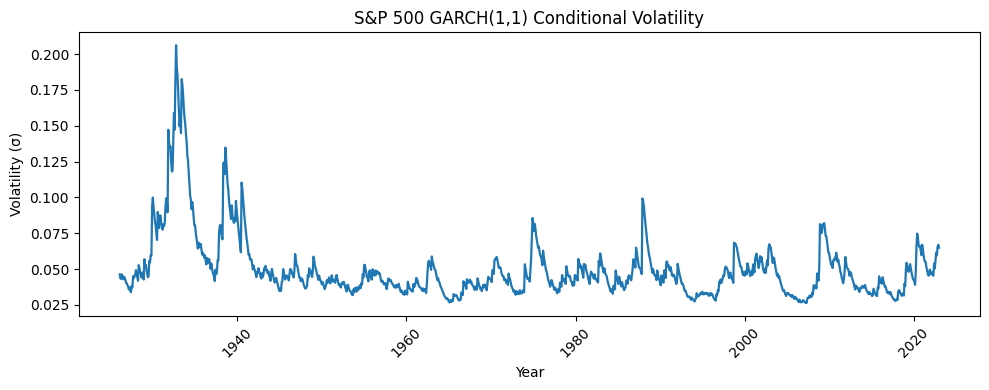

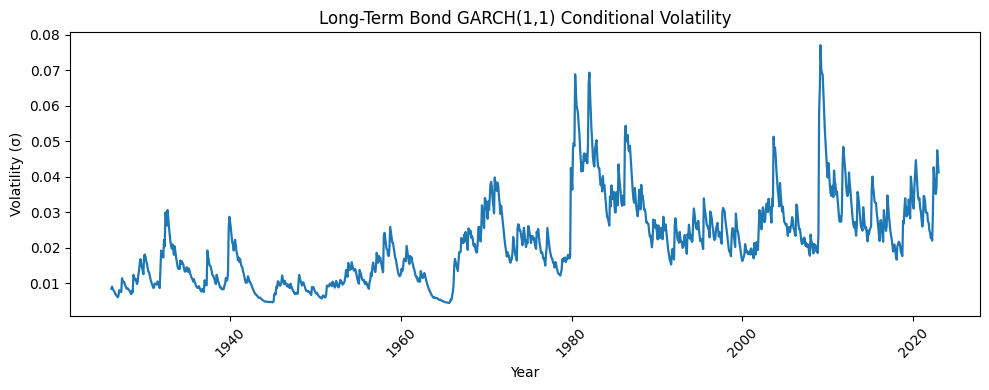

In [59]:
import matplotlib.dates as mdates
# Plot
n = len(vol_SP500_GARCH)
dates = pd.date_range("1926-01-31", periods=n, freq="ME")  
SP500 = vol_SP500_GARCH.reset_index(drop=True).set_axis(dates)
LTB   = vol_LTB_GARCH.reset_index(drop=True).set_axis(dates)

def plot_vol(series, title):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(series.index, series.values, linewidth=1.6)
    ax.set_title(title)
    ax.set_xlabel("Year"); ax.set_ylabel("Volatility (σ)")
    ax.xaxis.set_major_locator(mdates.YearLocator(20))  
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()

plot_vol(SP500, "S&P 500 GARCH(1,1) Conditional Volatility")
plot_vol(LTB,   "Long-Term Bond GARCH(1,1) Conditional Volatility")

In [62]:
non_missing_SP500 = excessrl_SP500.dropna().reset_index(drop=True)
dates = pd.date_range("1926-01-31", periods=len(non_missing_SP500), freq="ME")

vol_SP500 = vol_SP500_GARCH.dropna().reset_index(drop=True)
vol_SP500 = vol_SP500.iloc[:len(non_missing_SP500)]

realized_rolling_vol_12m = non_missing_SP500.rolling(12, min_periods=6).std()

table = pd.DataFrame({
    "date": dates,
    "non_missing_SP500": non_missing_SP500.values,                  
    "vol_SP500_GARCH": vol_SP500.values,        
    "realized_rolling_vol_12m": realized_rolling_vol_12m.values
})

csv_path = processed_path / "base_rep_SP500.csv"
table.to_csv(csv_path, index=False)
print("Saved:", csv_path.resolve())
table.tail(3)

Saved: C:\Users\Huong\OneDrive\Documents\Job\Project\early-regime\processed\base_rep_SP500.csv


,date,non_missing_SP500,vol_SP500_GARCH,realized_rolling_vol_12m
1161,2022-10-31,0.074893,0.065729,0.064263
1162,2022-11-30,0.049854,0.066912,0.066855
1163,2022-12-31,-0.063877,0.064899,0.066446
